# This is a minmal code fork of `Machine learning.ipynb`
With reduced output. Full output are in `Machine learning.ipynb`. Tt is on the "min scores 3" dateset, as it is much faster to run and there is not the point of failure of sharing models. 

In [1]:
test_size = 0.2 # default and reported 
# test_size = 0.5 # speed if you are in a hurry.

In [2]:
import random
import math
import sys
import gc
import re
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, SparsePCA, LatentDirichletAllocation, TruncatedSVD # aka LSA
from sklearn.preprocessing import *
from sklearn.preprocessing import MultiLabelBinarizer


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import * 


from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier # will not work for multi-label
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.tree import ExtraTreeClassifier as ET
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import torch
torch.cuda.is_available()

True

In [3]:
questions = pd.read_csv('./data/questions_preprocessed_min3.csv', index_col=0)
tags = pd.read_csv('./data/tags_preprocessed_min3.csv', index_col=0)

In [4]:
mlb = MultiLabelBinarizer()

list_to_encode = tags.Tag.values
mlb.fit(list_to_encode.reshape(-1,1))

encoded = dict() 
for i in tqdm(tags.index.unique()): 
    input_ = tags.loc[i, 'Tag']
    if (type(input_) is str):
        input_ = np.array(input_)
    else:   
        input_ = input_.values
    ouput_ = mlb.transform(input_.reshape(-1,1))
    ouput_ = list(np.sum(ouput_, axis=0))
    encoded[i] = ouput_

MultiLabelBinarizer()

100%|██████████| 160123/160123 [00:38<00:00, 4199.16it/s]


In [5]:
list_of_questions = []
list_of_tags = []
for i in tqdm(questions['Formatted'].index.unique()):
    list_of_questions.append(questions['Formatted'][i])
    list_of_tags.append(encoded[i])
print(f'length is {len(list_of_questions)}')

100%|██████████| 160123/160123 [00:00<00:00, 172732.68it/s]

length is 160123


In [6]:
# some of list_of_questions are nan. Im not sure how to deal with this.
bad_idx = []
for idx, i in enumerate(list_of_questions):
    if type(i) is not str:
        if math.isnan(i):
            list_of_questions[idx] = list_of_questions[idx+1]
            list_of_tags[idx] = list_of_tags[idx+1] 

In [7]:
print(f'Sample question: {list_of_questions[0]}\n')
print(f'Number of tags: {sum(list_of_tags[0])}')

Sample question: ASP NET Site Maps Has anyone got experience creating SQL based ASP NET site map providers ve got the default XML file web sitemap working properly with my Menu and SiteMapPath controls but ll need way for the users of my site to create and modify pages dynamically need to tie page viewing permissions into the standard ASP NET membership system as well 

Number of tags: 2


# Experiment 1: Encoding with Tokenizer, padding sequence

In [8]:
X_train, X_test, y_train, y_test = train_test_split(list_of_questions, list_of_tags, test_size=0.2, random_state=42)
y_train = np.asarray(y_train)
for i in range(len(y_train)):
    y_train[i] = np.array(y_train[i]) 
y_test = np.asarray(y_test)
for i in range(len(y_test)):
    y_test[i] = np.array(y_test[i])

In [9]:
tokenizer = Tokenizer(char_level=False, num_words=None, filters='!"()*+,-./:;<=>?@[\\]^_`{|}~\t\n') # #$%&
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1

maxlen = 167 # code to get mean ommited in this file
X_train = pad_sequences(X_train, padding='post', truncating='post', maxlen=maxlen)
X_test = pad_sequences(X_test,   padding='post', truncating='post', maxlen=maxlen)


In [10]:
def print_score(y_test, y_pred, clf=None):
    with warnings.catch_warnings():
        # print("Clf: ", clf.__class__.__name__)
        print(f"Accuracy score: {accuracy_score(y_true=y_test, y_pred=y_pred)}")
        print(f"Recall score: {recall_score(y_true=y_test, y_pred=y_pred, average='weighted')}")
        print(f"Precision score: {precision_score(y_true=y_test, y_pred=y_pred, average='weighted')}")
        f1 = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
        print(f"F1 score: {f1}")
        return f1

## Experiment 1 assessment - sklearn

In [10]:
clfs = []
# clfs.append(DecisionTreeClassifier(random_state=42))
clfs.append(ExtraTreesClassifier(n_estimators=15, random_state=42, n_jobs=-1))
clfs.append(RandomForestClassifier(n_estimators=15, random_state=42, n_jobs=-1))
# clfs.append(RadiusNeighborsClassifier(n_jobs=-1)) # takes a while
# clfs.append(KNeighborsClassifier(n_neighbors=10, n_jobs=-1)) # untested too long

for clf in clfs:
    start = time.time()
    _ = gc.collect()
    _ = clf.fit(X_train, y_train)
    print("Clf: ", clf.__class__.__name__)
    F1 = print_score(y_test, clf.predict(X_test), clf)
    print(f'Train score: {clf.score(X_train, y_train)}')
    print(f'Test score:  {clf.score(X_test, y_test)}')

    print(f'Time taken for {clf.__class__.__name__} was {time.time()-start:.2f}\n\n')

Clf:  ExtraTreesClassifier
Accuracy score: 0.0001249024199843872
Recall score: 0.0001756817427628882
Precision score: 0.15602100372835698
F1 score: 0.00035074026727097347
Train score: 1.0
Test score:  0.0001249024199843872
Time taken for ExtraTreesClassifier was 55.86


Clf:  RandomForestClassifier
Accuracy score: 0.0019047619047619048
Recall score: 0.0016982568467079193
Precision score: 0.229359021908164
F1 score: 0.0033224858662357637
Train score: 0.8793892176302518
Test score:  0.0019047619047619048
Time taken for RandomForestClassifier was 91.85




Clf:  MLPClassifier
Accuracy score: 0.0
Recall score: 7.808077456128365e-05
Precision score: 0.05107458665989967
F1 score: 0.0001556840539053019
Train score: 0.0
Test score:  0.0
Time taken for MLPClassifier was 104.67


<Figure size 576x216 with 0 Axes>

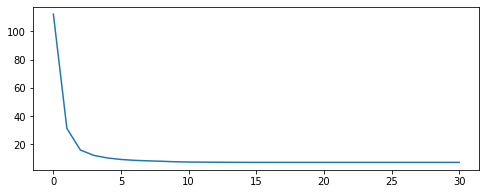

In [11]:
start = time.time()

clf = MLPClassifier(hidden_layer_sizes=(200, 100), random_state=42, max_iter=60)

clf = clf.fit(X_train, y_train)
print("Clf: ", clf.__class__.__name__)
F1 = print_score(y_test, clf.predict(X_test), clf)
print(f'Train score: {clf.score(X_train, y_train)}')
print(f'Test score:  {clf.score(X_test, y_test)}')
    
print(f'Time taken for {clf.__class__.__name__} was {time.time()-start:.2f}')

plt.figure(figsize=(8, 3))
plt.plot(clf.loss_curve_)

### In depth Eval of MLPClassifier, via argmax of `clf.predict_proba`

In [12]:
y_pred = clf.predict_proba(X_test)

y_pred_same_number_of_tags = [] # if average tags is 2.5, we are at a disadvantage if we do 2 or 3 tags.
for i in range(len(y_pred)):  
    best = y_pred[i].argsort()
    y_pred_ = np.zeros(y_pred.shape[1])
    number_of_tags = np.sum(y_test[i])
    y_pred_[best[-number_of_tags:]] = 1
    y_pred_same_number_of_tags.append(y_pred_)
    
_ = print_score(y_test, y_pred_same_number_of_tags) 
print("")

for i in range(5): # how many examples to print
    idx = np.random.randint(0, len(y_pred))
    print("y_pred:",', '.join(mlb.inverse_transform(y_pred_same_number_of_tags[idx].reshape(1,-1))[0]))
    print("y_test:",', '.join(mlb.inverse_transform(y_test[idx].reshape(1,-1))[0]))
    print('\n')

Accuracy score: 0.03731459797033568
Recall score: 0.12211833141384762
Precision score: 0.035572550178473994
F1 score: 0.04254961554891439

y_pred: c#, java
y_test: algorithm, c


y_pred: c#, java
y_test: generics, java


y_pred: c#
y_test: java


y_pred: c#
y_test: excel


y_pred: c#, java
y_test: c++, gcc




## Experiment 1 assessment - Basic LSTM

In [11]:
vocab_size = len(tokenizer.word_index) + 1
target_size = len(mlb.classes_)
embedding_dim = 300

In [12]:
## Build glove embdedding matrix
embeddings_dictionary = dict()
# glove_file = open('.\data\glove.42B.300d.txt', encoding="utf8")
glove_file = open('C:\\glove.42B.300d.txt', encoding="utf8")
for line in glove_file: # longer, by far
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

num_words_in_embedding = 0
# embedding_matrix = np.zeros((vocab_size, embedding_dim))
embedding_matrix = np.random.normal(scale=0.6, size=((vocab_size, embedding_dim)))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        num_words_in_embedding += 1
        embedding_matrix[index] = embedding_vector
        
print(f'portion of words in embedding: {num_words_in_embedding/vocab_size:.4f}')

portion of words in embedding: 0.2708


In [13]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input
# del model, opt, lr

loss = []
acc = []
val_loss = []
val_acc = []
checkpoint_file = 'ModelCheckpoint.h5'

In [14]:
output_dim = mlb.classes_.shape[0]
model = Sequential() ;_=gc.collect()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add((Bidirectional(LSTM(64, return_sequences=True))))
model.add(Dropout(0.05)) # technically not appropriate for a LSTM. recc_dropout is not on CuDNN
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(output_dim, activation='sigmoid')) # , activation='softmax')

opt = Adam(learning_rate=0.003)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc']) # categorical_crossentropy
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001)
cp = ModelCheckpoint(filepath=checkpoint_file, monitor='val_acc', save_best_only=True)

In [15]:
# model = keras.models.load_model("keras_lstm.h5")
# model.layers[0].trainable = True
history = model.fit(X_train, y_train, validation_split=0.05, epochs=10, batch_size=256, verbose=1, callbacks=[lr, cp])
loss.extend(history.history['loss'])
acc.extend(history.history['acc'])
val_loss.extend(history.history['val_loss'])
val_acc.extend(history.history['val_acc'])

Epoch 1/10
476/476 [==============================] - 25s 42ms/step - loss: 0.0811 - acc: 0.0683 - val_loss: 0.0727 - val_acc: 0.0709 - lr: 0.0030
Epoch 2/10
476/476 [==============================] - 19s 40ms/step - loss: 0.0700 - acc: 0.1107 - val_loss: 0.0630 - val_acc: 0.1769 - lr: 0.0030
Epoch 3/10
476/476 [==============================] - 19s 40ms/step - loss: 0.0548 - acc: 0.3134 - val_loss: 0.0452 - val_acc: 0.4306 - lr: 0.0030
Epoch 4/10
476/476 [==============================] - 19s 40ms/step - loss: 0.0419 - acc: 0.4848 - val_loss: 0.0374 - val_acc: 0.5199 - lr: 0.0030
Epoch 5/10
476/476 [==============================] - 19s 40ms/step - loss: 0.0361 - acc: 0.5473 - val_loss: 0.0336 - val_acc: 0.5539 - lr: 0.0030
Epoch 6/10
476/476 [==============================] - 19s 41ms/step - loss: 0.0327 - acc: 0.5742 - val_loss: 0.0315 - val_acc: 0.5655 - lr: 0.0030
Epoch 7/10
476/476 [==============================] - 19s 40ms/step - loss: 0.0306 - acc: 0.5903 - val_loss: 0.0302 - 

In [17]:
def test_keras_model(print_sample=False, X_test=X_test, model=model, y_test=y_test, topN=2):  
    y_pred = model.predict(X_test)
    y_pred_same_number_of_tags = [] # if average tags is 2.5, we are at a disadvantage if we do 2 or 3 tags.
    
    for i in range(len(y_pred)):  
        best = y_pred[i].argsort()
        y_pred_ = np.zeros(y_pred.shape[1])
        number_of_tags = np.sum(y_test[i])
        y_pred_[best[-number_of_tags:]] = 1
        y_pred_same_number_of_tags.append(y_pred_)
        
    _ = print_score(y_test, y_pred_same_number_of_tags) 

    # if print_sample:
    for i in range(print_sample):
        idx = np.random.randint(0, len(y_pred))
        print("y_pred:",', '.join(mlb.inverse_transform(y_pred_same_number_of_tags[idx].reshape(1,-1))[0]))
        print("y_test:",', '.join(mlb.inverse_transform(y_test[idx].reshape(1,-1))[0]))
        print('\n')

test_keras_model(print_sample=3)

Accuracy score: 0.6020921155347385
Recall score: 0.715629819047805
Precision score: 0.7067962826606747
F1 score: 0.6987501662669586
y_pred: php
y_test: php


y_pred: c++
y_test: c++


y_pred: android
y_test: android




In [18]:
_=gc.collect()
model.layers[0].trainable = True
history = model.fit(X_train, y_train, validation_split=0.05, epochs=5, batch_size=256, verbose=1, callbacks=[lr, cp])
# model.save("keras_lstm_min_3_score.h5")

loss.extend(history.history['loss'])
acc.extend(history.history['acc'])
val_loss.extend(history.history['val_loss'])
val_acc.extend(history.history['val_acc'])

# furture taining is omited from this file, I decreased LR and batch size

Epoch 1/5
476/476 [==============================] - 18s 38ms/step - loss: 0.0261 - acc: 0.6248 - val_loss: 0.0291 - val_acc: 0.5777 - lr: 0.0030
Epoch 2/5
476/476 [==============================] - 18s 38ms/step - loss: 0.0253 - acc: 0.6283 - val_loss: 0.0288 - val_acc: 0.5861 - lr: 0.0030
Epoch 3/5
476/476 [==============================] - 22s 45ms/step - loss: 0.0246 - acc: 0.6338 - val_loss: 0.0288 - val_acc: 0.5923 - lr: 0.0030
Epoch 4/5
476/476 [==============================] - ETA: 0s - loss: 0.0240 - acc: 0.6401
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009000000078231095.
476/476 [==============================] - 18s 38ms/step - loss: 0.0240 - acc: 0.6401 - val_loss: 0.0291 - val_acc: 0.5874 - lr: 0.0030
Epoch 5/5
476/476 [==============================] - 18s 38ms/step - loss: 0.0223 - acc: 0.6537 - val_loss: 0.0290 - val_acc: 0.5895 - lr: 9.0000e-04


#### This will print the top five most likely tags, and then the 4 metrics, in a manner such the the network preds the same number of tags as the ground truth

In [19]:
model.load_weights(checkpoint_file)
y_pred = model.predict(X_test)

topN = 5
y_pred_top = np.zeros_like(y_pred)
for i in range(y_pred.shape[0]):
    best = y_pred[i].argsort()
    y_pred_ = np.zeros(y_pred.shape[1])
    y_pred_[best[-topN:]] = 1
    y_pred_top[i] = y_pred_

for i in range(5): # how many examples to print
    idx = np.random.randint(0, len(y_pred))
    print("y_pred:",', '.join(mlb.inverse_transform(y_pred_top[idx].reshape(1,-1))[0]))
    print("y_test:",', '.join(mlb.inverse_transform(y_test[idx].reshape(1,-1))[0]))
    print('\n')
    

y_pred_same_number_of_tags = [] # if average tags is 2.5, we are at a disadvantage if we do 2 or 3 tags.
for i in range(len(y_pred)):  
    best = y_pred[i].argsort()
    y_pred_ = np.zeros(y_pred.shape[1])
    number_of_tags = np.sum(y_test[i])
    y_pred_[best[-number_of_tags:]] = 1
    y_pred_same_number_of_tags.append(y_pred_)
    
print(f'LSTM model scores')
_ = print_score(y_test, y_pred_same_number_of_tags) 

y_pred: c++, math, matlab, performance, r
y_test: r


y_pred: c++, c++11, exception, multithreading, python
y_test: c#, python


y_pred: database, hibernate, java, scala, spring
y_test: java


y_pred: asp.net, asp.net-mvc, c#, html, html5
y_test: asp.net-mvc


y_pred: .net, c#, exception, multithreading, oop
y_test: c#


LSTM model scores
Accuracy score: 0.6121779859484777
Recall score: 0.7236135782466963
Precision score: 0.7136606726367574
F1 score: 0.7096425380788987


```
on the all scores dataset "questions_preprocessed.csv"
2963/2963 [==============================] - 85s 29ms/step - loss: 0.0199 - acc: 0.6533 - val_loss: 0.0242 - val_acc: 0.6135 - lr: 5.0000e-04

Accuracy score: 0.6504909819639279
Recall score: 0.7615028687766056
Precision score: 0.7574494222705919
F1 score: 0.7544918807953225


on the min 3 scores dataset "questions_preprocessed_min3.csv"

1902/1902 [==============================] - 47s 25ms/step - loss: 0.0195 - acc: 0.6716 - val_loss: 0.0313 - val_acc: 0.5739 - lr: 1.5000e-04

Accuracy score: 0.6123965651834504
Recall score: 0.7221690839173125
Precision score: 0.7139613396235852
F1 score: 0.714711189087093


```

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'LSTM w/ GloVe Loss BCE')

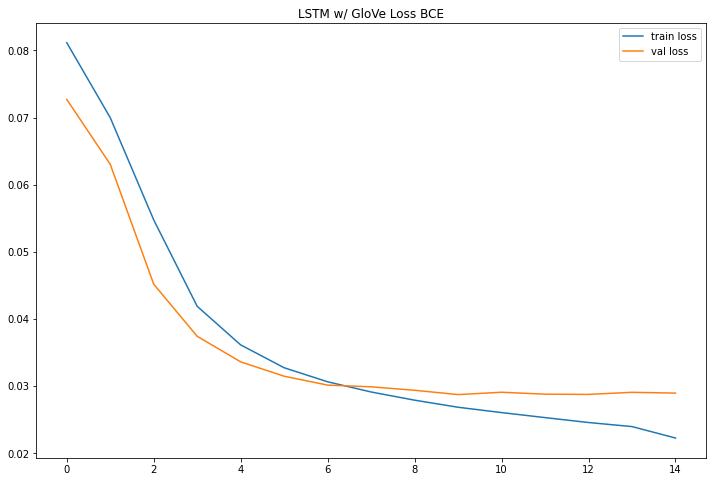

In [20]:
plt.figure(figsize=(12,8))
plt.title('LSTM w/ GloVe Loss BCE')
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend()
plt.show()

# Expirement 2: Encoding with TfidfVectorizer
> the following stats are for the `tags_preprocessed.csv` dataset

In [21]:
stop_words = None # there are maybe 300 stop words, and thousands of other features. i'm inclined to keep them around
min_df=318 # 3378 features

vectorizer = TfidfVectorizer(strip_accents='unicode', ngram_range=(1, 1), stop_words=stop_words, min_df=min_df)
docs       = vectorizer.fit_transform(list_of_questions)
features   = vectorizer.get_feature_names()
print(f'The number of features is {len(features)}')

The number of features is 3380


In [22]:
print(f'The number of samples is {docs.shape[0]} \nThe number of features is {docs.shape[1]}')

X_train, X_test, y_train, y_test = train_test_split(docs, list_of_tags, test_size=0.2, random_state=42)

y_train = np.asarray(y_train)
for i in range(len(y_train)):
    y_train[i] = np.array(y_train[i])
y_test = np.asarray(y_test)
for i in range(len(y_test)):
    y_test[i] = np.array(y_test[i])

The number of samples is 160123 
The number of features is 3380


In [23]:
clfs = []
# clfs.append(DecisionTreeClassifier(random_state=42))
clfs.append(ExtraTreesClassifier(n_estimators=10, random_state=42, n_jobs=3))
clfs.append(RandomForestClassifier(n_estimators=15, random_state=42, n_jobs=3))
# clfs.append(RadiusNeighborsClassifier(n_jobs=-1))

# clfs.append(KNeighborsClassifier(n_neighbors=10, n_jobs=-1)) # untested

for clf in clfs:
    start = time.time()
    _ = gc.collect()
    _ = clf.fit(X_train, y_train)
    
    print("Clf: ", clf.__class__.__name__)
    f1 = print_score(y_test, clf.predict(X_test))
    print(f'Train score: {clf.score(X_train, y_train)}')
    print(f'Test score:  {clf.score(X_test, y_test)}')

    print(f'Time taken for {clf.__class__.__name__} was {time.time()-start:.2f}\n\n')

Clf:  ExtraTreesClassifier
Accuracy score: 0.2553942232630757
Recall score: 0.30502254582365457
Precision score: 0.7926059155735715
F1 score: 0.41497574107200613
Train score: 1.0
Test score:  0.2553942232630757
Time taken for ExtraTreesClassifier was 169.82


Clf:  RandomForestClassifier
Accuracy score: 0.3110070257611241
Recall score: 0.38956450447988444
Precision score: 0.7770160992569072
F1 score: 0.48845383878318743
Train score: 0.953324798201377
Test score:  0.3110070257611241
Time taken for RandomForestClassifier was 182.87




Caution MLPClassifier can take long to train. I suggest max_iter=30 for performance, less for speed
Clf:  MLPClassifier
Accuracy score: 0.38348165495706477
Recall score: 0.559429229537957
Precision score: 0.750342277479494
F1 score: 0.6331531529800235
Train score: 0.4696248184983372
Test score:  0.38348165495706477
Time taken for MLPClassifier was 197.60


<Figure size 432x216 with 0 Axes>

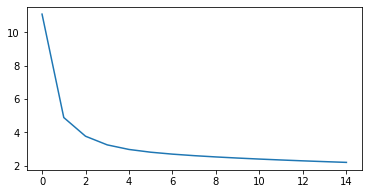

In [28]:
print('Caution MLPClassifier can take long to train. I suggest max_iter=30 for performance, less for speed')
start = time.time()

# clf = MLPClassifier(hidden_layer_sizes=(512, 100), random_state=42, max_iter=5)
clf = MLPClassifier(hidden_layer_sizes=(100), random_state=42, max_iter=15) # faster for eval

clf = clf.fit(X_train, y_train)

print("Clf: ", clf.__class__.__name__)
f1 = print_score(y_test, clf.predict(X_test))
print(f'Train score: {clf.score(X_train, y_train)}')
print(f'Test score:  {clf.score(X_test, y_test)}')
    
print(f'Time taken for {clf.__class__.__name__} was {time.time()-start:.2f}')

plt.figure(figsize=(6,3))
plt.plot(clf.loss_curve_)

# This is very slow. 30 mins
# Clf:  MLPClassifier
# Accuracy score: 0.33423887587822015
# Recall score: 0.5944094165414121
# Precision score: 0.6495997459270161
# F1 score: 0.6191668671471201
# Train score: 0.9959952536339365
# Test score:  0.33423887587822015
# Time taken for MLPClassifier was 1801.59

In [29]:
del clfs
_=gc.collect()

In [31]:
y_pred_same_number_of_tags = [] # if average tags is 2.5, we are at a disadvantage if we do 2 or 3 tags.
for i in range(len(y_pred)):  
    best = y_pred[i].argsort()
    y_pred_ = np.zeros(y_pred.shape[1])
    number_of_tags = np.sum(y_test[i])
    y_pred_[best[-number_of_tags:]] = 1
    y_pred_same_number_of_tags.append(y_pred_)
_ = print_score(y_test, y_pred_same_number_of_tags) 


# Accuracy score: 0.41033567525370807
# Recall score: 0.5303246208202386
# Precision score: 0.6853284607898511
# F1 score: 0.585585014891463

Accuracy score: 0.4272287275565964
Recall score: 0.5299146967537918
Precision score: 0.7665302501064949
F1 score: 0.6062759884972048


In [32]:
# without ensuring the same number of tags, we are at a disadvantage if we do 2 or 3 tags.

print("Train set")
_ = print_score(y_train, clf.predict(X_train)) 

print("Test set")
_ = print_score(y_test, y_pred) 

# Train set
# Accuracy score: 0.9959952536339365
# Recall score: 0.9989239633364962
# Precision score: 0.998521101023201
# F1 score: 0.9987211981852843
# Test set
# Accuracy score: 0.33423887587822015
# Recall score: 0.5944094165414121
# Precision score: 0.6495997459270161
# F1 score: 0.6191668671471201

Train set
Accuracy score: 0.4696248184983372
Recall score: 0.6360403807213358
Precision score: 0.8345773418819336
F1 score: 0.7106119253997064
Test set
Accuracy score: 0.38348165495706477
Recall score: 0.559429229537957
Precision score: 0.750342277479494
F1 score: 0.6331531529800235


In [36]:
y_pred = clf.predict(X_test[:])
for i in range(5):
    idx = np.random.randint(0, len(y_pred))
    print("y_pred_same_number_of_tags:",', '.join(mlb.inverse_transform(y_pred_same_number_of_tags[idx].reshape(1,-1))[0]))
    print("y_pred:",', '.join(mlb.inverse_transform(y_pred[idx].reshape(1,-1))[0]))
    print("y_test:",', '.join(mlb.inverse_transform(y_test[idx].reshape(1,-1))[0]))
    print('\n')


y_pred_same_number_of_tags: android
y_pred: android
y_test: android


y_pred_same_number_of_tags: python, xml
y_pred: python
y_test: image, python


y_pred_same_number_of_tags: oop, xml
y_pred: oop
y_test: c++, oop


y_pred_same_number_of_tags: xml
y_pred: 
y_test: oracle


y_pred_same_number_of_tags: css, google-chrome, html, xml
y_pred: css, html
y_test: css, javascript, jquery, twitter-bootstrap


